In [1]:
import geemap as gee
import ee
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import date, timedelta
from pyogrio import read_dataframe
import glob
import geopandas as gpd
import contextily as cx
import os
import standardize_pft_funcs as spf
import chardet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
try:
    ee.Initialize()
except Exception as e:
    print('GEE token expired. Use Jupyter Lab to authenticate')
    ee.Authenticate()

GEE token expired. Use Jupyter Lab to authenticate


Enter verification code:  4/1AeaYSHB9_xBtVJmH3tRg8NLQy4Ehe6hIpu8soS-YcMhjC3fafklgczLSG_8



Successfully saved authorization token.


# Read Turboveg Data

In [3]:
d = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/ak_tvexport_releves_header_data_for_vegbank_20181106_ALB.xlsx'
a = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/header_data_ckan_pubpage.xlsx'

In [4]:
data = read_dataframe(d, na_values=-9)
data = data.tail(-1)

## Extract all AVA data

In [5]:
# extract all AVA turboveg data
ava_points = gpd.GeoDataFrame(data, 
                              geometry=gpd.points_from_xy(data['Longitude (decimal degrees)'], data['Latitude (decimal degrees)']), 
                              crs="EPSG:4326")

## Extract post-2010 AVA data

In [6]:
# extract post-2000 AVA data
def getyear(row):
    string = str(row)
    date = string[:4]
    return int(date)

copy = ava_points.copy()
copy['Date (yyyymmdd)'] = copy['Date (yyyymmdd)'].astype(int)
copy['year'] = copy['Date (yyyymmdd)'].apply(getyear)
gte_2010 = copy[copy['year'] >= 2010]
len(gte_2010)

382

## Select post-2010 data

In [7]:
# extract all AVA turboveg data
ava_points = gpd.GeoDataFrame(gte_2010, 
                              geometry=gpd.points_from_xy(gte_2010['Longitude (decimal degrees)'], 
                                                          gte_2010['Latitude (decimal degrees)']), 
                              crs="EPSG:4326")

## Extract all AVA data within HUC

In [8]:
# load HUC data
huc = read_dataframe('/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/wbdhu6_a_us_september2022.gdb')
# select alaska HUCs and alaska HUCs of interest
ak_huc6 = huc[huc['states'].str.contains('AK')]
aois = ['190604', '190603', '190602']
huc_aoi = ak_huc6[ak_huc6['huc6'].isin(aois)]

In [9]:
# select all AVA data within the HUCs
poi = ava_points[ava_points.intersects(huc_aoi.unary_union)]

In [10]:
len(poi)

308

<Axes: >

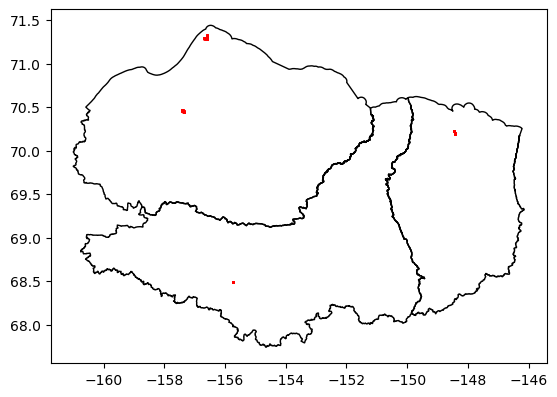

In [11]:
# plot bounding HUC and points of interest (poi)
ax = poi.plot(color="red", markersize=1)
huc_aoi.plot(ax=ax, edgecolor='black', facecolor='none')

## Extract all AVA data within Alaska Tundra

In [13]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska_polygon_latlon/'
f = 'tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(p + f)

In [14]:
ak_tundra.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
ava = ava_points.to_crs(ak_tundra.crs)
ak_tundra = ak_tundra.to_crs(ak_tundra.crs)

In [16]:
ava_tundra = ava.clip(ak_tundra)

In [17]:
len(ava_tundra)

308

<Axes: >

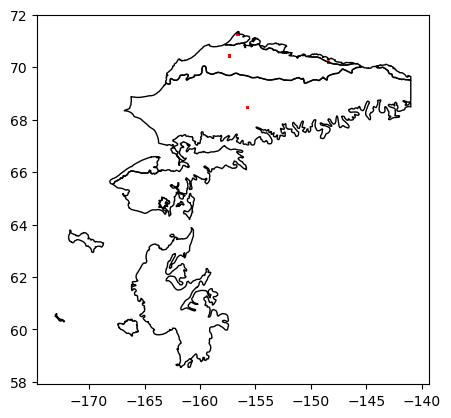

In [18]:
ax = ava_tundra.plot(color='red', markersize=1)
ak_tundra.plot(ax=ax, edgecolor='black', facecolor='none')

In [19]:
ak_tundra_datasets = sorted(ava_tundra['Dataset'].unique())

In [20]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/'
f = 'AKAVA_ak_tundra_datasets.csv'
pd.DataFrame(ak_tundra_datasets).to_csv(p + f)

## GEE Map

In [21]:
fc = gee.geopandas_to_ee(ak_tundra)
ha = gee.geopandas_to_ee(huc_aoi)

In [22]:
# extract geometry and unique ID
obs_geom = ava_tundra[['Latitude (decimal degrees)', 'Longitude (decimal degrees)', 'Releve number']]
# create ee object (feature collection)
obs_points = gee.df_to_ee(obs_geom, 
                          latitude='Latitude (decimal degrees)', 
                          longitude='Longitude (decimal degrees)')
# select points that intercept HUC
samplepoints = obs_points.filterBounds(fc)

In [23]:
samplepoints.size().getInfo()

308

In [24]:
GRIDSIZE = 18000
grid = fc.geometry().coveringGrid(proj='EPSG:4326', scale=GRIDSIZE)

# Create dictionary of grid coordinates
grid_dict = grid.getInfo()
feats = grid_dict['features']

# Create a list of several ee.Geometry.Polygons
polys = []
for d in feats:
    coords = d['geometry']['coordinates']
    poly = ee.Geometry.Polygon(coords)
    polys.append(poly)

num_km = GRIDSIZE / 1000
print(num_km)

18.0


In [25]:
len(polys)

4595

In [26]:
Map = gee.Map()
Map.center_object(fc, 6)
Map.addLayer(fc, {}, 'arctic')
Map.addLayer(samplepoints, {}, 'points')
#Map.addLayer((ee.FeatureCollection("USGS/WBD/2017/HUC06")
#             .filter(ee.Filter.inList('huc6', ['190604', '190603', '190602']))), {}, 'huc')
Map.addLayer(grid, {}, 'grid')
Map

Map(center=[66.56551547720869, -158.1544109640721], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
arctic_gdf = gee.ee_to_gdf(fc)
arctic_gdf.crs = 'epsg:4326'
arctic_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
gdf = gee.ee_to_gdf(grid)
gdf.crs = 'epsg:4326'
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
#gdf.to_file('/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska_grid', driver='ESRI Shapefile')
# arctic_gdf.to_file('/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska_wgs84/tundra+

## Turboveg Cover Columns

In [30]:
cover_cols = [col for col in ava_tundra.columns if 'Cover' in col]
cover = ava_tundra[cover_cols].copy()
cover.drop(columns=['Cover abundance scale'], inplace=True)
cover.index = list(ava_tundra['Releve number'])
cover.index = cover.index.astype(int)
cover.index.name = 'Releve number'

In [31]:
len(cover)

308

In [32]:
nonveg = cover[['Cover of soil crust (%)',
                'Cover bare soil (%)',
                'Cover rock (%)',
                'Cover water (%)']]
litter = cover[['Cover litter (%)']]

In [33]:
cols = pd.DataFrame(cover.columns.to_list())
cols.to_csv('/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/cover_column_headers.csv')

## Ancillary columns

In [34]:
ancillary_cols = [col for col in ava_tundra.columns if 'Cover' not in col]
ancillary = ava_tundra[ancillary_cols].copy()
ancillary

,Releve number,Field releve number,Date (yyyymmdd),Releve area (m2),Releve shape,Repeat sampled (y/n),Collection,Collection method,Syntaxon,System for plant community name,...,Vasc. plant taxonomic quality,Cryptogam taxonomic quality,Mean canopy height (cm),Mean tree layer height (m),Mean shrub layer height (cm),Mean herb layer height (cm),Mean moss layer height (cm),Remarks,geometry,year
3164,13164.0,T5-025-T,20150804,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,25.0,0.0,24.0,25.0,1.0,Low-centered polygons. Entered by L. Druckenmi...,POINT (-148.42701 70.19575),2015
3163,13163.0,T5-025-C,20150804,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,15.0,0.0,20.0,15.0,1.0,Low-centered polygons. Entered by L. Druckenmi...,POINT (-148.42681 70.19577),2015
3167,13167.0,T5-050-T-B,20150809,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,20.0,0.0,0.0,20.0,3.0,Low-centered polygons. Entered by L. Druckenmi...,POINT (-148.42764 70.19583),2015
3166,13166.0,T5-050-T-A,20150809,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,22.0,0.0,17.0,22.0,1.0,Low-centered polygons. Entered by L. Druckenmi...,POINT (-148.42764 70.19583),2015
3165,13165.0,T5-050-C,20150804,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,23.0,0.0,25.0,23.0,1.0,Low-centered polygons. Entered by L. Druckenmi...,POINT (-148.42751 70.19591),2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2788,12788.0,14-2,20140812,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,-9.0,-9.0,0.0,1.0,0.0,Entered by L. Druckenmiller and imported to TV...,POINT (-148.46774 70.22246),2014
2773,12773.0,T1-200-C,20140807,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,-9.0,-9.0,10.0,12.0,1.0,Black soil crust and White soil crust = Unknow...,POINT (-148.46917 70.22479),2014
2774,12774.0,T1-200-T,20140807,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,-9.0,-9.0,5.0,20.0,2.0,Entered by L. Druckenmiller and imported to TV...,POINT (-148.46933 70.22479),2014
2791,12791.0,14-5,20140813,1,square,N,Relevé,None,None,Field community name,...,1.0,1.0,-9.0,-9.0,2.0,14.0,2.0,Saxifraga hirculus noted outside the plot. Ent...,POINT (-148.46729 70.22611),2014


## Export original fcover and ancillary data

In [35]:
ancillary['Releve number'] = pd.to_numeric(ancillary['Releve number']).astype(int)
cover = pd.concat([cover, pd.to_numeric(ancillary['Releve number']).astype(int)], axis=1)
cover.set_index('Releve number', inplace=True)
ancillary.set_index('Releve number', inplace=True)

In [36]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/'
ancillary.to_csv(p + 'AKAVA_Turboveg_ancillary_00.csv')
cover.to_csv(p + 'AKAVA_Turboveg_original_fcover_00.csv')

# Begin standardization process

## Load all species-level fcover csv's

In [37]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/AKAVA_arctic_species_data'
spp_csvs = sorted(glob.glob(f'{p}/*.csv'))

In [38]:
dfs = []
for csv_path in spp_csvs:
    #print(csv_path)
    with open(csv_path, 'rb') as f:
        result = chardet.detect(f.read())
        #print(result['encoding'])
        df = pd.read_csv(csv_path, encoding=result['encoding'])
        dfs.append(df)

## Get unique genus-species names

In [39]:
# get accepted names (first column) from each csv
spp_names = []
for df in dfs: 
    spp_name = df.iloc[:, 0] # first col with author
    spp_names.append(spp_name)

In [40]:
# concatenate all spp names into one dataframe
all_spp_names = pd.concat(spp_names, ignore_index=True)
all_spp_names = pd.DataFrame(all_spp_names, columns=['Accepted Name'])
all_spp_names = all_spp_names.dropna().reset_index(drop=True)

In [41]:
# get unique species names
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg'
species = spf.get_unique_species(all_spp_names, 'Accepted Name', 'AKAVA', True, p)

Saved unique species list to /mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/AKAVA_unique_species.csv.


## Extract potential habits for each species

In [42]:
# load species checklist
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/akveg/'
f = 'AKVEG_species_checklist.csv'
checklist = read_dataframe(p + f)

# get first 2 words (genus-species) from checklist accepted name and data species name
checklist['Mapping Name'] = checklist['Accepted Name'].apply(spf.get_substrings)
species['Mapping Name'] = species['Accepted Name'].apply(spf.get_substrings)

In [43]:
habits = spf.fill_habits(unique_species=species, 
                         checklist=checklist, 
                         u_name='Accepted Name', 
                         c_unofficial_name='Name', 
                         c_official_name='Accepted Name', 
                         mapping_name='Mapping Name',
                         habit='Habit')

461 species are missing habits.
241 species still missing habits.
46 species still missing habits.
42 species still missing habits.


In [44]:
habits

,Name,Mapping Name,Habit
index,,,
0,Abietinella abietina,Abietinella abietina,moss
1,Acarospora schleicheri,Acarospora schleicheri,lichen
2,Achillea lanulosa,Achillea lanulosa,forb
3,Achillea millefolium s. borealis,Achillea millefolium,forb
4,Achillea millefolium subsp. borealis,Achillea millefolium,forb
...,...,...,...
1895,[UNKNOWN FRUTICOSE LICHEN],UNKNOWN FRUTICOSE,NaN
1896,[UNKNOWN LEAFY LIVERWORTS],UNKNOWN LEAFY,NaN
1897,[UNKNOWN MONOCOT],UNKNOWN MONOCOT,NaN


## Add evergreen/deciduous

In [45]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_post2000/'
f = 'evergreendecid_macander2022.csv'
evergrndecid = pd.read_csv(p + f, header=None)
evergrndecid.columns = ['evergreendecid', 'species']
final = spf.add_leaf_habit(habits, evergrndecid)

In [46]:
# export
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/'
f = 'AKAVA_species_habit_00.csv'
final.to_csv(p + f)

In [47]:
list(final['Potential Habit'].unique())

['moss',
 'lichen',
 'forb',
 'graminoid',
 'shrub, deciduous tree',
 'shrub',
 'liverwort',
 'dwarf shrub',
 'shrub, forb, dwarf shrub, shrub',
 'spore-bearing',
 'deciduous tree',
 ' tree, deciduous tree,dwarf shrub, shrub',
 nan,
 'shrub, dwarf shrub, shrub',
 'coniferous tree',
 'dwarf shrub, shrub',
 'shrub, tree, deciduous tree, shrub, dwarf shrub']

## Export shrubs, nonshrubs, null habit seperately

In [48]:
# get all shrub species
finalnonnull = final[~final['Potential Habit'].isnull()]
shrubs = finalnonnull[finalnonnull['Potential Habit'].str.contains('shrub')]
shrubs.to_csv(p + 'AKAVA_shrubs_00.csv')

In [49]:
# get all non-shrub species
nonshrubs = finalnonnull[~finalnonnull['Potential Habit'].str.contains('shrub')]
nonshrubs.to_csv(p + 'AKAVA_nonshrubs_00.csv')

In [50]:
# get null habits
finalnull = final[final['Potential Habit'].isnull()]
finalnull.to_csv(p + 'AKAVA_nullhabit_00.csv')

In [51]:
len(finalnull) + len(nonshrubs) + len(shrubs)

1900

In [52]:
len(final)

1900

## HERE: Manually add data from shrub05 file

## Standardize PFT Schema

In [53]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/'
nonshrub = 'AKAVA_nonshrubs_01.csv'
null = 'AKAVA_nullhabit_01.csv'
shrub = 'AKAVA_shrubs_01.csv'

alltypes = [nonshrub, shrub, null]

d = []
for t in alltypes:
    habits = pd.read_csv(p + t, index_col=0)
    d.append(habits)

In [54]:
completehabits = pd.concat(d)
completehabits['Habit'].unique().tolist()

['moss',
 'lichen',
 'forb',
 'graminoid',
 'liverwort',
 'spore-bearing',
 'deciduous tree',
 'coniferous tree',
 'shrub, tree',
 'shrub',
 'dwarf shrub',
 'algae',
 'cyanobacteria',
 'fungus',
 'bryophyte']

In [55]:
def standardize_habit_nonstandard(habitrow, leafrow, heightrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    heightrow = heightrow.to_numpy()
    new_row = []
    
    for habit, leaf, height in zip(habitrow, leafrow, heightrow):
        habit = habit.lower()
        if habit == 'shrub, tree':
            new_habit = f'{leaf} dwarf to tree cover (%)'
        elif habit == 'dwarf shrub':
            new_habit = f'{leaf} {habit} cover (%)'
        elif 'shrub' in habit:
            new_habit = f'{leaf} {height} cover (%)'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree cover (%)'
        else:
            new_habit = f'{habit} cover (%)'
        new_row.append(" ".join(new_habit.split()).lower())
    
    return new_row

In [56]:
def standardize_habit(habitrow, leafrow, heightrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    heightrow = heightrow.to_numpy()
    new_row = []
    
    for habit, leaf, height in zip(habitrow, leafrow, heightrow):
        habit = habit.lower()
        if 'algae' in habit or 'cyanobacteria' in habit:
            new_habit = 'lichen cover (%)'
        elif habit == np.nan or 'unknown' in habit:
            new_habit = 'unknown cover (%)'
        elif 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte cover (%)'
        elif 'spore-bearing' in habit:
            new_habit = 'forb cover (%)'
        elif habit == 'grass':
            new_habit = 'graminoid cover (%)'
            
        elif habit == 'shrub, tree':
            new_habit = f'{leaf} dwarf to tree cover (%)'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree cover (%)'
        elif habit == 'dwarf shrub':
            new_habit = f'{leaf} {habit} cover (%)'
        elif 'shrub' in habit:
            new_habit = f'{leaf} {height} cover (%)'
            
        elif 'litter' in habit or 'scat' in habit:
            new_habit = 'litter cover (%)'
        elif 'bare ground' in habit or 'crust' in habit or 'mineral' in habit:
            new_habit = 'bare ground cover (%)'
        else:
            new_habit = f'{habit} cover (%)'
        new_row.append(" ".join(new_habit.split()).lower())
    
    return new_row

In [57]:
# standardized PFT
standard_habit_col = standardize_habit(completehabits['Habit'], 
                                       completehabits['Leaf Retention'], 
                                       completehabits['Height'])

In [58]:
# non-standardized PFT
nonstandard_habit_col = standardize_habit_nonstandard(completehabits['Habit'], 
                                                      completehabits['Leaf Retention'],
                                                      completehabits['Height'])

In [59]:
completehabits['Standard Habit'] = standard_habit_col
completehabits['NonStandard Habit'] = nonstandard_habit_col

In [60]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/ava_turboveg/'
f = 'AKAVA_species_habit_standardized.csv'
completehabits.to_csv(p + f)

## Clean fcover data (standardize as percent)

In [61]:
spp = spp_csvs

In [58]:
def get_fcover_percent(spp, habit_name):
    
    plot_data = []
    names = [os.path.basename(x) for x in spp]
    convs = []
    for n in names:
        conv = n.split('_')[-2]
        convs.append(conv)
    finalhabits = completehabits[['Name', habit_name]]
    
    
    for s, conv in zip(spp, convs):

        # read species data
        with open(s, 'rb') as f:
            result = chardet.detect(f.read())
            df = pd.read_csv(s, encoding=result['encoding'], header=0)
        print(habit_name, s, end='\x1b[1K\r')

        # rename columns
        cols = df.columns.to_numpy()
        cols[0] = 'Name'
        cols[1] = 'Name NoAuthor'
        cols[2] = 'Study Name'
        df.columns = cols

        # select plot TIDs
        tid_cols = df.columns.to_list()[3:]

        # get habit for each species in file
        plotlevel_habit = df.merge(finalhabits, left_on='Name', right_on='Name') # survey plot names will be dropped here

        # br-bq to percentage conversion dict
        bb_dict = {'r': 0.05, '+': 0.55, '1': 3.0, '2': 15.0, '3': 37.5, '4': 62.5, '5': 87.5, '-9': np.nan}
        # Westoff converstion dict
        wv_dict = {'1': 0.05, '2': 1.0, '3': 2.5, '4': 4.5, '5': 9.0, '6': 18.5, '7': 37.0, '8': 62.0, '9': 87.5}
        # Hult-Serander conversion dict
        hs_dict = {'+': 0.5, '1': 4.0, '2': 9.0, '3': 18.0, '4': 38.0, '5': 63.0, '6': 87.0}

        # convert wv codes
        if conv == 'wv':

            # replace westoff-van den maarel code with percentage
            cols = plotlevel_habit.columns.to_list()
            plotlevel_habit = plotlevel_habit.astype(str)
            for col in cols:
                plotlevel_habit.replace({col: wv_dict}, inplace=True)

        # covert br-bl codes        
        elif conv == 'brbl':

            # replace br-bl code with percentage
            cols = plotlevel_habit.columns.to_list()
            plotlevel_habit = plotlevel_habit.astype(str)
            for col in cols:
                plotlevel_habit.replace({col: bb_dict}, inplace=True)

        elif conv == 'hs':

            # replace hs code with percentage
            cols = plotlevel_habit.columns.to_list()
            plotlevel_habit = plotlevel_habit.astype(str)
            for col in cols:
                plotlevel_habit.replace({col: hs_dict}, inplace=True)

        # if already percent
        else:

            plotlevel_habit = plotlevel_habit.astype(str)

        # clean % data
        plot_pft = plotlevel_habit.drop(columns=['Name NoAuthor', 'Name', 'Study Name'])
        plot_pft = plot_pft.loc[:, plot_pft.columns != habit_name].replace(' ', '0', regex=True)
        plot_pft = plot_pft.loc[:, plot_pft.columns != habit_name].replace('', '0', regex=True)
        plot_pft = plot_pft.loc[:, plot_pft.columns != habit_name].replace('\*', '0', regex=True)
        plot_pft = plot_pft.loc[:, plot_pft.columns != habit_name].astype(float)

        # add back the standard habit column
        plot_pft[habit_name] = plotlevel_habit[habit_name] # replace codes with new fcover %

        # loop through each plot and sum fcover per pft
        final = plot_pft.groupby(by=[habit_name]).sum().T
        final.index = tid_cols
        plot_data.append(final)
        
    return plot_data

In [59]:
# this section is working on ALL plot data
sf = get_fcover_percent(spp, 'Standard Habit')
nsf = get_fcover_percent(spp, 'NonStandard Habit')

In [60]:
standard_fcover = pd.concat(sf, axis=0)
nonstandard_fcover = pd.concat(nsf, axis=0)

In [61]:
standard_fcover.index.name = 'Site Code'
standard_fcover.index = standard_fcover.index.astype(str)
standard_fcover.columns.name = None
nonstandard_fcover.index = nonstandard_fcover.index.astype(str)
nonstandard_fcover.columns.name = None

## Standardize fcover data

In [62]:
def add_standard_cols(groups):
    
    # required columns
    necessary_cols = ['deciduous dwarf shrub cover (%)',
                      'deciduous dwarf to low shrub cover (%)',
                      'deciduous dwarf to tall shrub cover (%)',
                      'deciduous dwarf to tree cover (%)',
                      'deciduous tree cover (%)',
                      'evergreen dwarf shrub cover (%)',
                      'evergreen dwarf to low shrub cover (%)',
                      'evergreen dwarf to tall shrub cover (%)',
                      'evergreen dwarf to tree cover (%)',
                      'evergreen tree cover (%)',
                      'bryophyte cover (%)',
                      'forb cover (%)',
                      'graminoid cover (%)',
                      'lichen cover (%)']
    
    # add missing columns and fill with nan
    cols = groups.columns.tolist()
    addcols = []
    for nc in necessary_cols:
        if nc not in cols:
            addcols.append(nc)
    groups[addcols] = np.nan
    return groups

In [63]:
standard_fcover = add_standard_cols(standard_fcover)

## Check total/top
Sum non-vegetaion, see if any PFT (max PFT) is greater than the remainder

If non-veg is always smaller than vegetation, than non-vegetation is probably top cover

In [64]:
# clean up nonveg (this df has correct number of sites)
nonveg2 = nonveg.copy()
nonveg2 = nonveg2.astype(float)
nonveg2 = nonveg2.where(nonveg2 != -9.0, np.NaN)
nonveg2.index.name = 'Site Code'
nonveg2.index = nonveg2.index.astype(str)

# clean up litter
litter2 = litter.copy()
litter2 = litter2.astype(float)
litter2 = litter2.where(litter2 != -9.0, np.NaN)
litter2.index.name = 'Site Code'
litter2.index = litter2.index.astype(str)

In [65]:
nonvegsum = nonveg2.sum(axis=1)
nonvegsum = pd.DataFrame(nonvegsum, columns=['nonveg_fcover'])

In [66]:
vegmax = standard_fcover.max(axis=1)
vegmax = pd.DataFrame(vegmax, columns=['max_veg_fcover'])
idx = vegmax.index.astype(str)
vegmax.index = idx

In [67]:
maxs = pd.concat([vegmax, nonvegsum], axis=1)

In [68]:
# replace 0 with NaN and drop rows with all NaN
maxs = maxs.replace(0.0, np.NaN)
maxs = maxs.dropna(axis=0, how='all')

In [69]:
maxs = maxs.replace(np.NaN, 0.0)
maxs['nonveg_remainder'] = 100 - maxs['nonveg_fcover']
maxs['top_or_total'] = np.where(maxs['max_veg_fcover'] < maxs['nonveg_remainder'], 'top', 'total')
maxs['top_or_total'] = np.where(maxs['nonveg_fcover'] == 0, 'na', maxs['top_or_total'])
maxs['maxveg > nonveg_remainder'] = np.where(maxs['max_veg_fcover'] > maxs['nonveg_remainder'], True, False)

In [70]:
maxs.index = maxs.index.astype(int)

In [71]:
maxs = maxs[maxs.index.isin(nonveg.index.tolist())]

## Read ancillary

In [72]:
anc = ancillary.copy()
# year
anc['year'] = anc['Date (yyyymmdd)'].astype(int)
anc['year'] = anc['Date (yyyymmdd)'].astype(str).str[:4]
anc['year'] = anc['year'].astype('Int64')
# plot size
anc['Releve area (m2)'].replace(-1, np.NaN)
anc['plot_radius_m'] = np.sqrt(anc['Releve area (m2)'].astype(float)) / 2
#anc['plot_radius_m'] = anc['plot_radius_m'].astype(str).str.extract('(\d+)')
# dataset source
anc['source'] = 'AKAVA'
anc['subsource'] = anc['Dataset']
anc.rename(columns={'Latitude (decimal degrees)':'latitude',
                    'Longitude (decimal degrees)':'longitude'}, inplace=True)
anc.index.name = 'Site Code'
#anc.index = anc.index.astype(str)

In [73]:
anc = anc[['latitude', 'longitude', 'year', 'plot_radius_m', 'source', 'subsource']]

In [74]:
maxs_w_anc = pd.concat([maxs, anc], axis=1, join='inner')

In [75]:
maxs_w_anc_2010 = maxs_w_anc.copy()
maxs_w_anc_2010 = maxs_w_anc[maxs_w_anc_2010['year'] >= 2010]
maxs_w_anc_2010_samp = maxs_w_anc_2010.sample(n=20)

In [76]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/AK-AVA_Turboveg/'
maxs_w_anc.to_csv(p + 'nonveg_cover_type.csv')
maxs_w_anc_2010_samp.to_csv(p + 'nonveg_cover_type_p2010.csv')

## Rename non-veg and drop 100% water plots

In [77]:
# assume non-veg is total cover
nonveg2.rename(columns={'Cover of soil crust (%)':'bare ground top cover (%)',
                       'Cover bare soil (%)':'bare ground top cover (%)',
                       'Cover rock (%)':'bare ground top cover (%)',
                       'Cover water (%)':'water top cover (%)'},
              inplace=True)
nonveg2 = nonveg2.groupby(lambda x:x, axis=1).sum()
nonveg2 = nonveg2[nonveg2['water top cover (%)'] != 100]
nonwater_idx = nonveg2.index.tolist()

## Create total cover file (not merged)

In [78]:
# set index and sort columns
totcover_nm = nonstandard_fcover.copy()
totcover_nm.drop(columns=['fungus cover (%)'], inplace=True)
#select plots of interest using inner join -- litter 2 has correct num of plots
totcover_nm = pd.concat([totcover_nm, litter2], axis=1, join='inner')
totcover_nm.rename(columns={'Cover litter (%)':'litter cover (%)'}, inplace=True)
len(totcover_nm)

308

In [79]:
totcover_nm.columns.name = None
totcover_nm = totcover_nm[sorted(totcover_nm.columns.tolist())]
totcover_nm.index.name = 'Site Code'

In [80]:
# add "total cover" to column names
cols = totcover_nm.columns.tolist()
cols = [x.replace('cover (%)' , 'total cover (%)') for x in cols]
totcover_nm.columns = cols
totcover_nm = totcover_nm.groupby(lambda x:x, axis=1).sum() #remove duplicate cols

In [81]:
# add ancillary
totcover_nm.index = totcover_nm.index.astype(str)
anc.index = anc.index.astype(str)
totcover_nm = pd.concat([totcover_nm, anc], axis=1)
totcover_nm.replace(0.0, np.NaN, inplace=True)

In [82]:
# drop 100% water
totcover_nm = totcover_nm.loc[nonwater_idx]

In [83]:
# export
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_04/original_files/'
f = 'AKAVA_fcover_total_orig.csv'
totcover_nm.to_csv(p + f)

In [84]:
len(totcover_nm)

275

## Create total cover file (merged)

In [85]:
# set index and sort columns
totcover = standard_fcover.copy()
totcover = pd.concat([litter2, totcover], axis=1, join='inner')
totcover.rename(columns={'Cover litter (%)':'litter cover (%)'}, inplace=True)
totcover.drop(columns=['fungus cover (%)'], inplace=True)
totcover.columns.name = None
totcover = totcover[sorted(totcover.columns.tolist())]
totcover.index.name = 'Site Code'
totcover.index = totcover.index.astype(str)

In [86]:
# add "total cover" to column names
cols = totcover.columns.tolist()
cols = [x.replace('cover (%)' , 'total cover (%)') for x in cols]
totcover.columns = cols

In [87]:
totcover = pd.concat([nonveg2, totcover], axis=1)
totcover = totcover.groupby(lambda x:x, axis=1).sum() #remove duplicate cols
totcover.drop(columns=['bare ground top cover (%)', 'water top cover (%)'], inplace=True)

In [88]:
# add ancillary
totcover2 = pd.concat([totcover, anc], axis=1)
totcover2.replace(0.0, np.NaN, inplace=True)
totcover2.index.name = 'Site Code'

In [89]:
# drop 100% water
totcover2 = totcover2.loc[nonwater_idx]

In [90]:
# export
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_04/original_files/'
f = 'AKAVA_fcover_total_merged.csv'
totcover2.to_csv(p + f)

In [91]:
len(totcover2)

275

## non-veg top cover

In [92]:
top = pd.concat([nonveg2, anc], axis=1, join='inner')
top.replace(0.0, np.NaN, inplace=True)
top.index.name = 'Site Code'

In [93]:
# drop 100% water
top = top.loc[nonwater_idx]

In [94]:
# export
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_04/original_files/'
f = 'AKAVA_fcover_top_nonPFT.csv'
top.to_csv(p + f)

In [95]:
len(top)

275

## Concat total and top into one file

In [96]:
allveg = pd.concat([totcover2, top], axis=1)
covercols = sorted([col for col in allveg.columns if 'cover (%)' in col])
the_rest = sorted([col for col in allveg.columns if not 'cover (%)' in col])
c = allveg[covercols]
r = allveg[the_rest]
final_all = pd.concat([c,r], axis=1)
# remove duplicate columns
final_all = final_all.loc[:,~final_all.columns.duplicated()].copy()

In [97]:
final_all.columns

Index(['bare ground top cover (%)', 'bryophyte total cover (%)',
       'deciduous dwarf shrub total cover (%)',
       'deciduous dwarf to low shrub total cover (%)',
       'deciduous dwarf to tall shrub total cover (%)',
       'deciduous dwarf to tree total cover (%)',
       'deciduous tree total cover (%)',
       'evergreen dwarf shrub total cover (%)',
       'evergreen dwarf to low shrub total cover (%)',
       'evergreen dwarf to tall shrub total cover (%)',
       'evergreen dwarf to tree total cover (%)',
       'evergreen tree total cover (%)', 'forb total cover (%)',
       'graminoid total cover (%)', 'lichen total cover (%)',
       'litter total cover (%)', 'water top cover (%)', 'latitude',
       'longitude', 'plot_radius_m', 'source', 'subsource', 'year'],
      dtype='object')

In [99]:
# export
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/temp/'
f = 'AVA_fcover_child.csv'
final_all.to_csv(p + f)

## Aggregate child plots to parent plots

In [100]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [101]:
# load cover file
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/temp/'
f = 'AVA_fcover_child.csv'
akava = pd.read_csv(p + f)

# only plots with very small sizes need to be processed, 
# the other remains the same, discarding all plots earlier than 2010
akava['plot_radius_m'].astype(float)
akava_small_fcover = akava[(akava['plot_radius_m']<10) &  (akava['year']>=2010)]
akava_large_fcover = akava[(akava['plot_radius_m']>=10) &  (akava['year']>=2010)]

In [102]:
len(akava_small_fcover)

275

In [103]:
selected_columns = ['Site Code','year','latitude', 'longitude', 'source', 'subsource', 'plot_radius_m']
akava_small = akava_small_fcover[selected_columns]
# akava_small = akava.fillna(0)
akava_small.head()

,Site Code,year,latitude,longitude,source,subsource,plot_radius_m
0,11600,2010,71.288212,-156.682645,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5
1,11599,2010,71.289576,-156.691514,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5
2,11598,2010,71.289508,-156.690180,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5
3,11593,2010,71.289531,-156.689706,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5
4,11595,2010,71.289509,-156.686935,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5


In [104]:
#### transform geographic to utm so that distance caculation is more intuitive
from pyproj import Transformer
src_crs = "EPSG:4326"
target_crs = "EPSG:32606"
transformer = Transformer.from_crs(src_crs, target_crs)

lon = akava_small['longitude'].to_numpy()
lat = akava_small['latitude'].to_numpy()

#### store the projected coords
projcoords = []   
for i in range(0,akava_small.shape[0]):
    xcoord, ycoord = lon[i],lat[i]
    projcoords.append(transformer.transform(ycoord,xcoord))

In [105]:
#### calculate the distance matrix of all small plots (for examination)
from scipy.spatial.distance import cdist
coord = np.array(projcoords)
dist_mat = cdist(coord, coord, 'euclidean')
# dist_mat[:3,:] <= 60

In [106]:
### group pixels/plots based on their euclidean distance
def group_pixels_by_distance(pixel_data, distance_threshold):
    """
        pixel_data: ndarray of coordinate pair: n by 2, default is utm projection
        distance_threshold: threshold used for grouping, default is 60m
        
        return:
        a list of values indicating the group id of each pixel
    
    """
    cluster_id = 0
    pixel_clusters = {}
   
    def expand_cluster(pixel, cluster_id):
        if pixel_clusters.get(cluster_id) is None:
            pixel_clusters[cluster_id] = []
       
        pixel_clusters[cluster_id].append(pixel)

    cluster_array = np.full(len(pixel_data), -1)  # Initialize with -1 (unassigned)
   
    for i, pixel in enumerate(pixel_data):
        assigned = False
       
        for c_id, cluster_pixels in pixel_clusters.items():
            cluster_pixels = np.array(cluster_pixels)
            distances = np.linalg.norm(cluster_pixels - pixel, axis=1)
            if np.any(distances <= distance_threshold):
                expand_cluster(pixel, c_id)
                assigned = True
                cluster_array[i] = c_id
                break
       
        if not assigned:
            expand_cluster(pixel, cluster_id)
            cluster_array[i] = cluster_id
            cluster_id += 1

    return cluster_array

dist_thres = 55
coord = np.array(projcoords)  ## UTM coords, unit is meter
group = group_pixels_by_distance(coord, dist_thres)

In [107]:
### add the group id to df for aggregation
akava_small['group_id'] = group
akava_small.head()

,Site Code,year,latitude,longitude,source,subsource,plot_radius_m,group_id
0,11600,2010,71.288212,-156.682645,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5,0
1,11599,2010,71.289576,-156.691514,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5,1
2,11598,2010,71.289508,-156.690180,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5,1
3,11593,2010,71.289531,-156.689706,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5,1
4,11595,2010,71.289509,-156.686935,AKAVA,Barrow IBP Tundra Biome_Pat Webber (Webber 1978),0.5,2


In [109]:
groups = akava_small.groupby(['group_id', 
                              'year', 'source']).agg({'latitude':'mean',
                                            'longitude':'mean',
                                            'Site Code':list,
                                            'plot_radius_m':list,
                                            'subsource':set})

In [110]:
groups

,,,latitude,longitude,Site Code,plot_radius_m,subsource
group_id,year,source,,,,,
0,2010,AKAVA,71.288212,-156.682645,[11600],[0.5],{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
1,2010,AKAVA,71.289538,-156.690467,"[11599, 11598, 11593]","[0.5, 0.5, 0.5]",{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
2,2010,AKAVA,71.289509,-156.686935,[11595],[0.5],{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
3,2010,AKAVA,71.288892,-156.680604,"[11594, 11602, 11596]","[0.5, 0.5, 0.5]",{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
4,2010,AKAVA,71.288333,-156.676383,[11622],[0.5],{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
...,...,...,...,...,...,...,...
84,2014,AKAVA,70.222151,-148.472511,[12783],[0.5],{Prudhoe ArcSEES road study_Donald Walker (Wal...
85,2014,AKAVA,70.223167,-148.471293,"[12781, 12779, 12777, 12775, 12776, 12787, 127...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",{Prudhoe ArcSEES road study_Donald Walker (Wal...
86,2014,AKAVA,70.222445,-148.467781,"[12789, 12788]","[0.5, 0.5]",{Prudhoe ArcSEES road study_Donald Walker (Wal...


In [111]:
def get_plot_size(rowlst):
    if len(rowlst) == 1:
        val = rowlst[0]
    else:
        val = 55
    return val
groups['plot_radius_m'] = groups['plot_radius_m'].apply(lambda row: get_plot_size(row))
groups

,,,latitude,longitude,Site Code,plot_radius_m,subsource
group_id,year,source,,,,,
0,2010,AKAVA,71.288212,-156.682645,[11600],0.5,{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
1,2010,AKAVA,71.289538,-156.690467,"[11599, 11598, 11593]",55.0,{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
2,2010,AKAVA,71.289509,-156.686935,[11595],0.5,{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
3,2010,AKAVA,71.288892,-156.680604,"[11594, 11602, 11596]",55.0,{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
4,2010,AKAVA,71.288333,-156.676383,[11622],0.5,{Barrow IBP Tundra Biome_Pat Webber (Webber 19...
...,...,...,...,...,...,...,...
84,2014,AKAVA,70.222151,-148.472511,[12783],0.5,{Prudhoe ArcSEES road study_Donald Walker (Wal...
85,2014,AKAVA,70.223167,-148.471293,"[12781, 12779, 12777, 12775, 12776, 12787, 127...",55.0,{Prudhoe ArcSEES road study_Donald Walker (Wal...
86,2014,AKAVA,70.222445,-148.467781,"[12789, 12788]",55.0,{Prudhoe ArcSEES road study_Donald Walker (Wal...


In [117]:
groups2 = groups.explode('Site Code')

In [118]:
groups2.reset_index(inplace=True)
groups2['parent_id'] = (groups2['group_id'].astype(str) + 
                        '_' + groups2['year'].astype(str) +
                        '_' + groups2['source'])
groups2.rename(columns={'latitude':'parent_latitude',
                        'longitude':'parent_longitude'},
               inplace=True)
groups2.drop(columns=['group_id', 'year', 'source', 'subsource'], inplace=True)
groups2

,parent_latitude,parent_longitude,Site Code,plot_radius_m,parent_id
0,71.288212,-156.682645,11600,0.5,0_2010_AKAVA
1,71.289538,-156.690467,11599,55.0,1_2010_AKAVA
2,71.289538,-156.690467,11598,55.0,1_2010_AKAVA
3,71.289538,-156.690467,11593,55.0,1_2010_AKAVA
4,71.289509,-156.686935,11595,0.5,2_2010_AKAVA
...,...,...,...,...,...
270,71.321623,-156.605577,13080,55.0,87_2014_AKAVA
271,71.321623,-156.605577,13076,55.0,87_2014_AKAVA
272,71.321623,-156.605577,13077,55.0,87_2014_AKAVA
273,71.324245,-156.607965,13072,55.0,88_2014_AKAVA


In [119]:
groups2.set_index('Site Code', inplace=True)
asf = akava_small_fcover.set_index('Site Code')
asf.drop(columns=['plot_radius_m'], inplace=True)
joined = pd.concat([asf, groups2], axis=1)
joined.columns

Index(['bare ground top cover (%)', 'bryophyte total cover (%)',
       'deciduous dwarf shrub total cover (%)',
       'deciduous dwarf to low shrub total cover (%)',
       'deciduous dwarf to tall shrub total cover (%)',
       'deciduous dwarf to tree total cover (%)',
       'deciduous tree total cover (%)',
       'evergreen dwarf shrub total cover (%)',
       'evergreen dwarf to low shrub total cover (%)',
       'evergreen dwarf to tall shrub total cover (%)',
       'evergreen dwarf to tree total cover (%)',
       'evergreen tree total cover (%)', 'forb total cover (%)',
       'graminoid total cover (%)', 'lichen total cover (%)',
       'litter total cover (%)', 'water top cover (%)', 'latitude',
       'longitude', 'source', 'subsource', 'year', 'parent_latitude',
       'parent_longitude', 'plot_radius_m', 'parent_id'],
      dtype='object')

In [122]:
info_cols = ['parent_latitude', 'parent_longitude', 'plot_radius_m'] #create parent coord by finding mean
data_cols = [col for col in joined.columns if 'cover (%)' in col]
anci_cols = set(joined.columns) - set(data_cols) - set(info_cols)

In [127]:
info_dict = dict.fromkeys(info_cols, 'mean')
data_dict = dict.fromkeys(data_cols, 'mean')
anci_dict = dict.fromkeys(anci_cols, set)
d = {**data_dict, **info_dict, **anci_dict}

parent_plots = joined.groupby('parent_id').agg(d)

In [128]:
parent_plots.drop(columns=['latitude', 'longitude', 'parent_id', 
                           'source'],
                 inplace=True)

In [129]:
parent_plots['year'] = parent_plots['year'].explode()
parent_plots['source'] = 'AKAVA'
parent_plots['subsource'] = parent_plots['subsource'].apply(list)
parent_plots.rename(columns={'Site Code':'child_site_codes',
                             'parent_longitude':'longitude',
                             'parent_latitude':'latitude'}, 
                    inplace=True)
parent_plots.index.name = 'Site Code'

In [130]:
parent_plots

,bare ground top cover (%),bryophyte total cover (%),deciduous dwarf shrub total cover (%),deciduous dwarf to low shrub total cover (%),deciduous dwarf to tall shrub total cover (%),deciduous dwarf to tree total cover (%),deciduous tree total cover (%),evergreen dwarf shrub total cover (%),evergreen dwarf to low shrub total cover (%),evergreen dwarf to tall shrub total cover (%),...,graminoid total cover (%),lichen total cover (%),litter total cover (%),water top cover (%),latitude,longitude,plot_radius_m,year,subsource,source
Site Code,,,,,,,,,,,,,,,,,,,,,
0_2010_AKAVA,NaN,6.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.100000,NaN,18.000000,50.0,71.288212,-156.682645,0.5,2010,[Barrow IBP Tundra Biome_Pat Webber (Webber 19...,AKAVA
10_2010_AKAVA,NaN,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.500000,NaN,3.000000,69.0,71.296217,-156.700917,0.5,2010,[Barrow IBP Tundra Biome_Pat Webber (Webber 19...,AKAVA
11_2010_AKAVA,NaN,32.37,1.500000,NaN,11.666667,NaN,NaN,NaN,NaN,NaN,...,27.346667,1.896667,28.666667,NaN,71.294623,-156.688007,55.0,2010,[Barrow IBP Tundra Biome_Pat Webber (Webber 19...,AKAVA
12_2010_AKAVA,NaN,20.90,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.420000,4.230000,31.000000,NaN,71.294297,-156.686482,0.5,2010,[Barrow IBP Tundra Biome_Pat Webber (Webber 19...,AKAVA
13_2010_AKAVA,NaN,35.40,29.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.900000,13.160000,16.000000,NaN,71.295368,-156.685757,0.5,2010,[Barrow IBP Tundra Biome_Pat Webber (Webber 19...,AKAVA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86_2014_AKAVA,61.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.250000,NaN,4.000000,NaN,70.222445,-148.467781,55.0,2014,[Prudhoe ArcSEES road study_Donald Walker (Wal...,AKAVA
87_2014_AKAVA,16.666667,23.70,27.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.366667,20.060000,12.666667,5.0,71.321623,-156.605577,55.0,2014,[Flux Tower Zona_Scott Davidson (Davidson et a...,AKAVA
88_2014_AKAVA,NaN,78.05,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.550000,11.700000,12.500000,NaN,71.324245,-156.607965,55.0,2014,[Flux Tower Zona_Scott Davidson (Davidson et a...,AKAVA


In [131]:
p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/temp/'
f = 'AVA_fcover_parent.csv'
parent_plots.to_csv(p + f)

## total/top cover parent test 04

In [427]:
# # ancillary
# noncover = [col for col in parent_plots.columns if not 'cover (%)' in col]
# noncover = parent_plots[noncover]
# # total
# totcover_parent = [col for col in parent_plots.columns if 'total cover (%)' in col]
# totcover_parent = parent_plots[totcover_parent]
# # top
# topcover_parent = [col for col in parent_plots.columns if 'top cover (%)' in col]
# topcover_parent = parent_plots[topcover_parent]

In [428]:
# totcover_parent = pd.concat([totcover_parent, noncover], axis=1)
# topcover_parent = pd.concat([topcover_parent, noncover], axis=1)

In [429]:
# # total
# p = '/mnt/poseidon/remotesensing/arctic/data/training/Test_04/original_files/'
# f = 'AKAVA_PARENT_fcover_total_merged.csv'
# totcover_parent.to_csv(p + f)
# # top
# f = 'AKAVA_PARENT_fcover_top_nonPFT.csv'
# topcover_parent.to_csv(p + f)

## Map parent and child plots

In [480]:
p = '/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska/'
f = 'tundra_alaska.shp'
ak_tundra = gpd.read_file(p + f)

In [481]:
fc = gee.geopandas_to_ee(ak_tundra)

In [482]:
pp2 = parent_plots.reset_index()

In [483]:
par_geom = pp2[['Site Code', 'latitude', 'longitude']]
par_points = gee.df_to_ee(par_geom, 
                          latitude='latitude', 
                          longitude='longitude')

In [484]:
gte_geom = gte_2010[['Releve number', 
                     'Latitude (decimal degrees)', 'Longitude (decimal degrees)']]
gte_points = gee.df_to_ee(gte_geom, 
                          latitude='Latitude (decimal degrees)', 
                          longitude='Longitude (decimal degrees)')

In [485]:
Map = gee.Map()
Map.center_object(fc, 6)
Map.addLayer(fc, {}, 'arctic')
Map.addLayer(gte_points, {}, 'child')
Map.addLayer(par_points, {'color':'red'}, 'parent')
Map

Map(center=[66.56551547720869, -158.1544109640721], controls=(WidgetControl(options=['position', 'transparent_…